### Import Library

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

### Import Data

In [2]:
random_state = 23873

dt = pd.read_excel(r'CA_BC.xlsx').T
dt.columns = dt.iloc[0]
dt = dt.iloc[1:]
dt['Label'] = dt.Label.map({'E':1,'A':0})

dt.drop_duplicates(keep='first',inplace=True)
for x in dt.select_dtypes(include=['object']).columns:
    dt[x] = dt[x].astype('float64')
dt.columns = [str(x) for x in dt.columns]
dt = dt.select_dtypes(include=['float64','int64'])


## Handle Duplicate Columns

# Columns to not rename
excluded = dt.columns[~dt.columns.duplicated(keep=False)]

# An incrementer
import itertools
inc = itertools.count().__next__

# A renamer
def ren(name):
    return f"{name}{inc()}" if name not in excluded else name

# Use inside rename()
for x in range(0,2):
    dt.rename(columns=ren,inplace=True)

In [3]:
f1_cols = {
    'LogisticRegression':['LOC101060339', 'LOC90784', 'MGC22265', 'PWP2', 'LOC100133331', 'TMLHE'],
    'ExtraTree':['LOC90784', 'TUBB8', 'CCL3L3', 'GPR173', 'IKBKE', 'ENTHD2', 'PRIMPOL'],
    'RandomForest':['LOC101060339','MGC22265','CHD1','FAM207A','C2ORF71','AMACR','CCDC154'],
    'LGBM':['LOC101060339','LOC100133331','TTC30B','MGC14226','COL6A5','SCN7A','FLJ41941','AP5M1','GALNT1','TFRC','NAP1L4','PEG3-AS1','LOC115451','HOXA11-AS'],
    'Adaboost': ['LOC101060339','CMT2B1','MAP7D1','LOC90784','MGC23947','OGFOD2','DKFZP434N231','MPI','LIMK1','DHX40P','MGC22265'],
    'SVM':['LOC90784','PIF1','LOC101060247','KBF2','STON1-GTF2A1L','CYP4V2','KCNE3','STYXL1','KIAA1324L','DKFZp434E1822','RPS26P11','ZNF702P','LOC101060339']
}

In [4]:
recall_cols = {
    'LogisticRegression':['LOC90784','ENTHD2','CCL4L1','ACCPN','PWP2','PRKY','LINC00965','FOXQ1','RPS26P11','KATNBL1P6'],
    'ExtraTree':['LOC90784', 'TUBB8', 'CCL3L3', 'GPR173', 'IKBKE'],
    'RandomForest':['LOC101060339', 'MGC22265', 'CHD1', 'ZNF816', 'ZC3H12A', 'MINK1'],
    'LGBM':['LOC101060339','LOC100133331','TTC30B','MGC14226','COL6A5','SCN7A','LOC96800','GSG2','PLSCR3'],
    'Adaboost':['LOC101060339', 'LOC90784', 'PWP2', 'MGC22265', 'TYSND1'],
    'SVM':['LOC90784','KBF2','DDX51','ADGRF2','LOC101060247','RPS26P11','CCL4L1','LOC101060339','DKFZp434E1822']
}

In [5]:
random_state = 23923
pipes = {
        'LogisticRegression':Pipeline([('scaler', StandardScaler()),('model', LogisticRegression())]),
         'ExtraTree': Pipeline([('scaler', MinMaxScaler()),('model', ExtraTreesClassifier(n_estimators =10, random_state = random_state))]),
         'RandomForest':Pipeline([('scaler', MinMaxScaler()),('model', RandomForestClassifier(n_estimators =10, random_state = random_state))]),
         'LGBM':Pipeline([('scaler', MinMaxScaler()),('model', LGBMClassifier(random_state = random_state))]),
         'Adaboost':Pipeline([('scaler', MinMaxScaler()),('model', AdaBoostClassifier(n_estimators =10, random_state = random_state))]),
         'SVM':Pipeline([('scaler', MinMaxScaler()),('model', SVC(kernel='linear'))])
}

In [6]:
def classifier(x_train, x_test, y_train, y_test,classifier,model):
    # Training the classifier
    model.fit(x_train, y_train.values.ravel())

    print(f"*************************{classifier}****************************")

    # Printing Accuracy on Training and Test sets
    print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
    print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")

    # Printing classification report of classifier on the test set set data
    print(f"Model Classification Report : \n{classification_report(y_test, model.predict(x_test))}")
    return None

In [7]:
features = dt.copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state) 

In [8]:
for x in list(pipes.keys()):
    cols = recall_cols[x]
    classifier(x_train[cols],x_test[cols], y_train, y_test,x,pipes[x])

*************************LogisticRegression****************************
Training Set Score : 98.87640449438202 %
Test Set Score : 94.87179487179486 %
Model Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.93      1.00      0.96        27

    accuracy                           0.95        39
   macro avg       0.97      0.92      0.94        39
weighted avg       0.95      0.95      0.95        39

*************************ExtraTree****************************
Training Set Score : 100.0 %
Test Set Score : 92.3076923076923 %
Model Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.93      0.96      0.95        27

    accuracy                           0.92        39
   macro avg       0.92      0.90      0.91        39
weighted avg       0.92      0.92      0.92        39

******

In [14]:
def modelling_mulitple(x_train, y_train,col_list):

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    f1_mean,f1_std,recall_mean,recall_std = [],[],[],[]

    classifiers = list(pipes.keys())

    scoring = {'f1_macro': 'f1_macro',
               'recall_macro': 'recall_macro'
              }

    for classifier in list(pipes.keys()):
            scores = cross_validate(pipes[classifier], x_train[col_list[classifier]], y_train, scoring=scoring, cv=cv)
            f1_mean.append(scores['test_f1_macro'].mean())
            f1_std.append(scores['test_f1_macro'].std())
            recall_mean.append(scores['test_recall_macro'].mean())
            recall_std.append(scores['test_recall_macro'].std())

    cv_res = pd.DataFrame(data={'Algorithms':classifiers, 'F1 Mean Score':f1_mean, 'F1 std':f1_std,
                               'Recall Mean Score':recall_mean, 'Recall std':recall_std
                               })

    plt.rcParams["figure.figsize"] = [8.00, 5.00]
    plt.rcParams["figure.autolayout"] = True
#     f, axes = plt.subplots(1, 2)

    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2").set(title='Cross Validation Scores')
#     sns.barplot(x = 'Recall Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    plt.savefig('final.eps',bbox_inches = 'tight',dpi=1200,transparent= True, format='eps')


    return cv_res

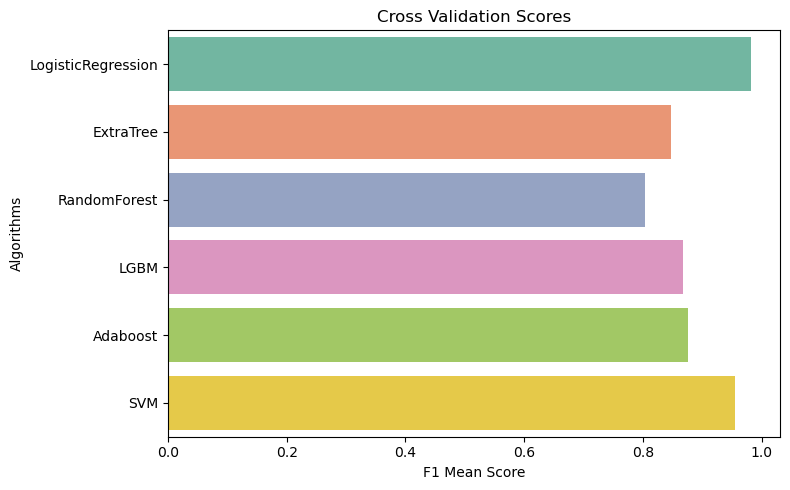

In [15]:
features = dt.copy()
target = features.pop('Label')
cv_res = modelling_mulitple(features,target,f1_cols)

In [18]:
print(cv_res.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
        Algorithms &  F1 Mean Score &   F1 std &  Recall Mean Score &  Recall std \\
\midrule
LogisticRegression &       0.981784 & 0.018230 &           0.976136 &    0.023918 \\
         ExtraTree &       0.846896 & 0.069009 &           0.846050 &    0.067817 \\
      RandomForest &       0.803731 & 0.142923 &           0.808820 &    0.143631 \\
              LGBM &       0.866809 & 0.017384 &           0.874188 &    0.028551 \\
          Adaboost &       0.875199 & 0.075161 &           0.862500 &    0.083960 \\
               SVM &       0.954245 & 0.015594 &           0.946591 &    0.024346 \\
\bottomrule
\end{tabular}



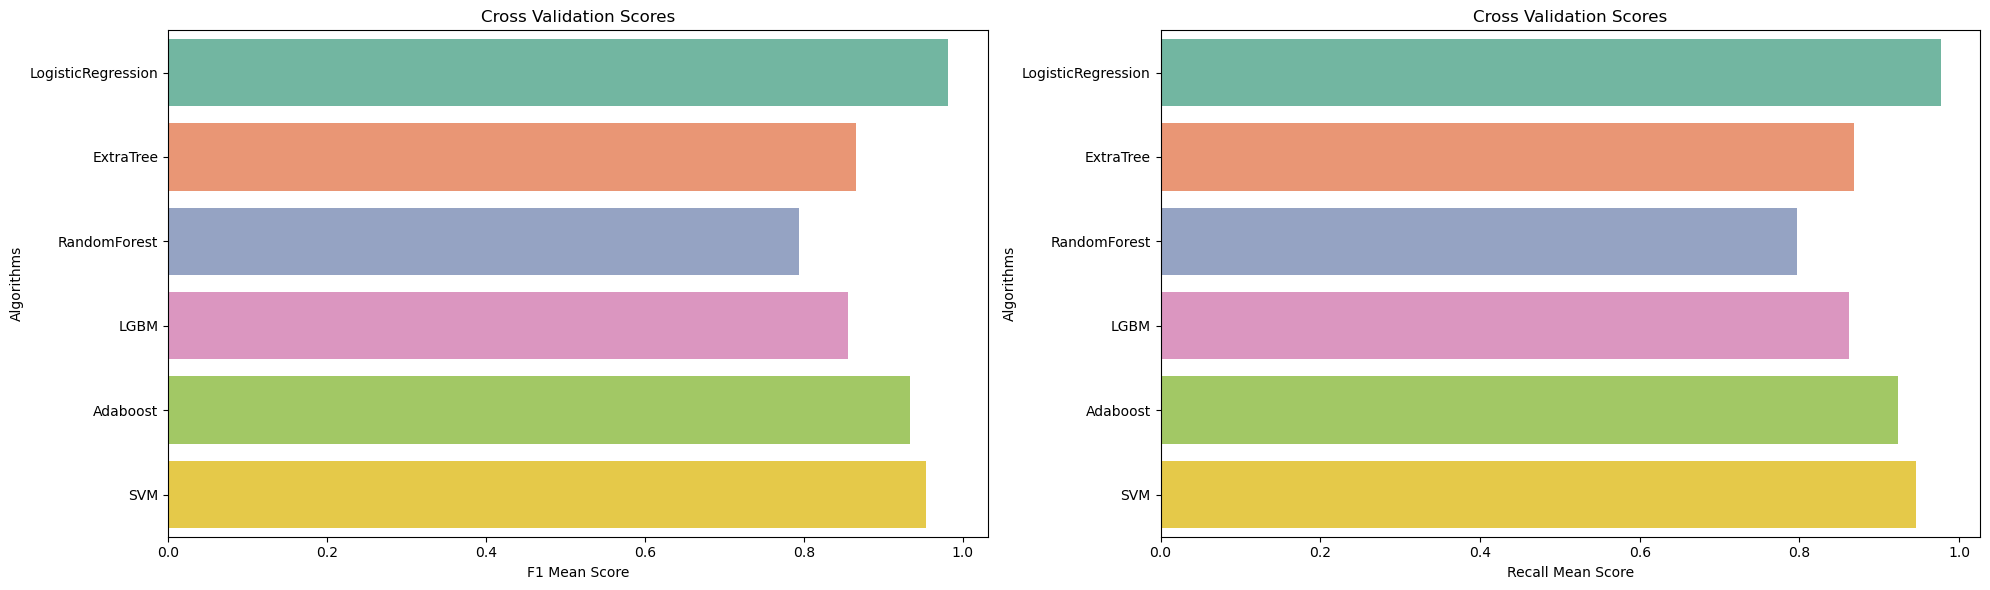

,Algorithms,F1 Mean Score,F1 std,Recall Mean Score,Recall std
0,LogisticRegression,0.981818,0.031492,0.977273,0.039365
1,ExtraTree,0.865770,0.040677,0.868777,0.044076
2,RandomForest,0.793559,0.050709,0.797186,0.057536
3,LGBM,0.855882,0.056893,0.861688,0.064508
4,Adaboost,0.933814,0.057152,0.923864,0.066446
5,SVM,0.953714,0.040908,0.945455,0.043952


In [11]:
features = dt.copy()
target = features.pop('Label')
modelling_mulitple(features,target,recall_cols)
